<h3>  &nbsp;&nbsp;Train on GPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

1. On the main menu, click Runtime and select **Change runtime type**. Set "GPU" as the hardware accelerator.
1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER. 

In [123]:
import tensorflow.keras as keras
keras.__version__

'2.4.0'

In [124]:
import numpy as np
import tensorflow
import re
import sklearn.model_selection as sk

In [125]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

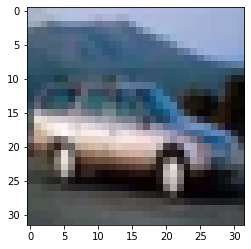

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

train_images

digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)

plt.show()

In [127]:
# MODIFY THE CODE TO ADD A VALIDATION SET

train_images = keras.applications.mobilenet.preprocess_input(train_images)

test_images = keras.applications.mobilenet.preprocess_input(test_images)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

test_images, validation_images,  test_labels, validation_labels = sk.train_test_split(test_images, test_labels, test_size=0.5)


In [128]:
#VGG gives very poor results, probably due to too many parameters
#Xception goes around 0.7 acc when used with images of (72,72);
#I accidentally overwritten the densenet121.png (after 20 epochs it achieved 0.86 acc so i decided to stick with mobilenet which gave much better results)
#some improvement in first epochs after adding regularizers but the model struggles later  

In [129]:
from tensorflow.keras.applications import MobileNet

input_tensor = keras.Input(shape=(32, 32, 3))
resized_images = keras.layers.Lambda(lambda image: tensorflow.image.resize(image, (224, 224)))(input_tensor)


conv_base = MobileNet(weights='imagenet',
                  include_top=False,
                  input_tensor=resized_images,
                  pooling='avg',
                  input_shape=(224, 224, 3))

In [130]:
#conv_base.summary()

In [131]:
conv_base.trainable = False

In [132]:
initializer = keras.initializers.he_normal()

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, 
                       kernel_initializer=initializer,
                       activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10,
                       kernel_initializer=initializer,
                       activation='sigmoid'))

In [133]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
flatten_10 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                2570      
Total params: 3,493,834
Trainable params: 264,970
Non-trainable params: 3,228,864
_________________________________________________________________


In [134]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

lr_reduce = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                          factor=0.5,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)

In [135]:
  # MAKE WHATEVER CHANGES ARE NECESSARY
  # TO GET 0.7 ACCURACY ON THE TEST SET

model_hist = model.fit(train_images, train_labels,
          epochs=20, batch_size=128, callbacks=[lr_reduce], validation_data=(validation_images, validation_labels), verbose=1)
          # ADD VALIDATION HERE)

Epoch 1/20
391/391 [==============================] - 31s 79ms/step - loss: 1.3479 - acc: 0.5363 - val_loss: 0.6484 - val_acc: 0.8006
Epoch 2/20
391/391 [==============================] - 30s 78ms/step - loss: 0.7800 - acc: 0.7444 - val_loss: 0.5099 - val_acc: 0.8332
Epoch 3/20
391/391 [==============================] - 30s 78ms/step - loss: 0.6328 - acc: 0.7908 - val_loss: 0.4467 - val_acc: 0.8486
Epoch 4/20
391/391 [==============================] - 30s 78ms/step - loss: 0.5530 - acc: 0.8142 - val_loss: 0.4183 - val_acc: 0.8582
Epoch 5/20
391/391 [==============================] - 30s 78ms/step - loss: 0.5052 - acc: 0.8296 - val_loss: 0.3985 - val_acc: 0.8644
Epoch 6/20
391/391 [==============================] - 31s 79ms/step - loss: 0.4705 - acc: 0.8418 - val_loss: 0.3877 - val_acc: 0.8692
Epoch 7/20
391/391 [==============================] - 30s 77ms/step - loss: 0.4411 - acc: 0.8491 - val_loss: 0.3750 - val_acc: 0.8730
Epoch 8/20
391/391 [==============================] - 31s 78ms

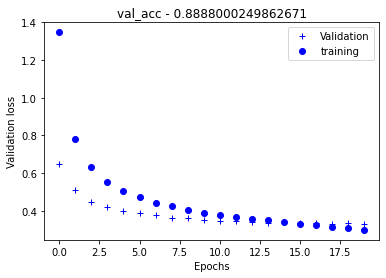

In [139]:
import matplotlib.pyplot as plt

epochs = range(0, 20)
train_loss = model_hist.history['loss']
val_loss= model_hist.history['val_loss']
val_acc = model_hist.history['val_acc'][-1]

plt.plot(epochs, val_loss, 'b+', label='Validation')
plt.plot(epochs, train_loss, 'bo', label='training')
plt.title('val_acc - {}'.format(val_acc))
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.savefig('{}.png'.format(conv_base.name.replace(".","_")))
plt.show()


In [137]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test_acc:', test_acc)
test_loss

157/157 [==============================] - 3s 20ms/step - loss: 0.3160 - acc: 0.8888
test_acc: 0.8888000249862671


0.3160334527492523

In [138]:
model.save_weights('./cifar10.h5', overwrite=True)